# New libraries to install

In [ ]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 6.8 MB/s 
     |████████████████████████████████| 9.9 MB 57.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


# Connection to drive and path definition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/final/SANDS')
path_files ='/content/drive/MyDrive/Colab Notebooks/final/UC4'

# Import libraries

In [ ]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import time
from calendar import timegm, monthrange
from datetime import datetime, timedelta
import math
import sands
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from os import listdir
from os.path import isfile, join
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import CategoricalAccuracy,Accuracy,BinaryAccuracy


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import ExponentialSmoothing
from pmdarima.arima import auto_arima
from scipy.stats import iqr

# Data generation

In [ ]:
parameters1 = {
        'time_delta':5
    }

In [ ]:
metric_df = sands.generate_device_metric_time_range(datetime.strptime('10/01/22 00:00:01', '%m/%d/%y %H:%M:%S'),datetime.strptime('10/01/22 00:00:01', '%m/%d/%y %H:%M:%S')+timedelta(days=29),parameters1,['PE-5'],['bng_subscribers'])


In [ ]:
metric_df.to_csv(join(path_files,'bng_subscribers_metric_forecast.csv'))

In [ ]:
metric_df=pd.read_csv(join(path_files,'bng_subscribers_metric_forecast.csv'),index_col=0)

In [ ]:
metric_df

,timestamp,bng_subscribers,device_name,vendor,model,os,version,hw_revision,role,ip_address
0,1664582401,700.572875,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
1,1664582701,699.180130,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
2,1664583001,708.998684,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
3,1664583301,688.517726,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
4,1664583601,718.203977,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
...,...,...,...,...,...,...,...,...,...,...
8347,1667086501,2891.532965,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
8348,1667086801,2051.840208,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
8349,1667087101,2591.565752,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
8350,1667087401,2592.219241,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5


# Data preparation

In [ ]:
ds_column = []
for i,obs in metric_df.iterrows():
    #new_timestamp = datetime.fromtimestamp(obs['timestamp']).strftime('%Y-%m-%d %H:%M:%S')
    new_timestamp = datetime.fromtimestamp(obs['timestamp'])
    ds_column.append(new_timestamp)
metric_df['ds']=ds_column
metric_df['y']=metric_df['bng_subscribers']



In [ ]:
metric_df

,timestamp,bng_subscribers,device_name,vendor,model,os,version,hw_revision,role,ip_address,ds,y
0,1664582401,700.572875,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-01 00:00:01,700.572875
1,1664582701,699.180130,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-01 00:05:01,699.180130
2,1664583001,708.998684,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-01 00:10:01,708.998684
3,1664583301,688.517726,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-01 00:15:01,688.517726
4,1664583601,718.203977,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-01 00:20:01,718.203977
...,...,...,...,...,...,...,...,...,...,...,...,...
8347,1667086501,2891.532965,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-29 23:35:01,2891.532965
8348,1667086801,2051.840208,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-29 23:40:01,2051.840208
8349,1667087101,2591.565752,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-29 23:45:01,2591.565752
8350,1667087401,2592.219241,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-29 23:50:01,2592.219241


Text(0.5, 1.0, 'BNG Subscribers')

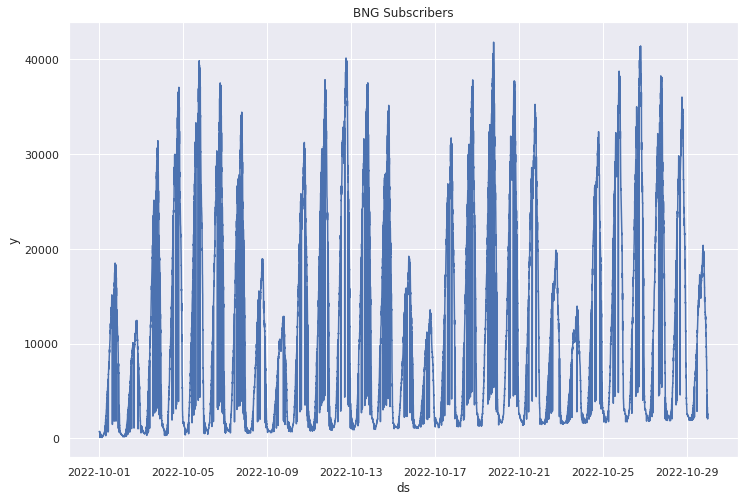

In [ ]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=metric_df['ds'], y=metric_df['y'])
plt.title('BNG Subscribers')

In [ ]:
df = metric_df[['ds','y']].set_index('ds')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8352 entries, 2022-10-01 00:00:01 to 2022-10-29 23:55:01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       8352 non-null   float64
dtypes: float64(1)
memory usage: 130.5 KB


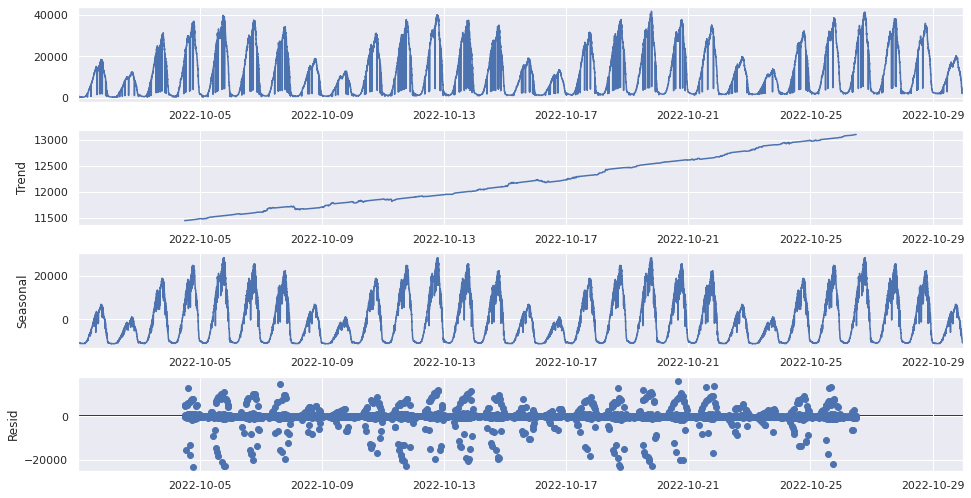

(ds
 2022-10-01 00:00:01   NaN
 2022-10-01 00:05:01   NaN
 2022-10-01 00:10:01   NaN
 2022-10-01 00:15:01   NaN
 2022-10-01 00:20:01   NaN
                        ..
 2022-10-29 23:35:01   NaN
 2022-10-29 23:40:01   NaN
 2022-10-29 23:45:01   NaN
 2022-10-29 23:50:01   NaN
 2022-10-29 23:55:01   NaN
 Name: trend, Length: 8352, dtype: float64, ds
 2022-10-01 00:00:01   -10751.948619
 2022-10-01 00:05:01   -10556.941955
 2022-10-01 00:10:01   -10553.620323
 2022-10-01 00:15:01   -10556.145355
 2022-10-01 00:20:01   -10549.812817
                            ...     
 2022-10-29 23:35:01   -10536.233712
 2022-10-29 23:40:01   -10246.823368
 2022-10-29 23:45:01   -10571.583431
 2022-10-29 23:50:01   -10754.750461
 2022-10-29 23:55:01   -10560.277169
 Name: seasonal, Length: 8352, dtype: float64, ds
 2022-10-01 00:00:01   NaN
 2022-10-01 00:05:01   NaN
 2022-10-01 00:10:01   NaN
 2022-10-01 00:15:01   NaN
 2022-10-01 00:20:01   NaN
                        ..
 2022-10-29 23:35:01   NaN
 2022-

In [ ]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive',period=2016)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual

seasonal_decompose(df)

# Naive model

We want to forecast 1 day, which means 288 observations.

given it is seasonal, we can assume the baseline is prediction based on the same observation on the last seasonal period. The seasonality is weekly. One period = 2016 samples. So we will look at the sample-2016 to predict the next 288 observations

naive prediction: y_pred = y[t-2016]

In [ ]:
y_pred_naive = df['y'][:-2016].values.reshape(-1,1)

In [ ]:
y_pred_naive.shape

(6336, 1)

In [ ]:
df.loc[df.index[2016:],'y_pred_naive']=y_pred_naive

In [ ]:
df

,y,y_pred_naive
ds,,
2022-10-01 00:00:01,694.311087,NaN
2022-10-01 00:05:01,688.075266,NaN
2022-10-01 00:10:01,717.926268,NaN
2022-10-01 00:15:01,705.764107,NaN
2022-10-01 00:20:01,719.646520,NaN
...,...,...
2022-10-29 23:35:01,2904.299204,2488.258534
2022-10-29 23:40:01,2901.800268,2473.012022
2022-10-29 23:45:01,2599.680563,2144.410500


In [ ]:
performance_naive_MAE = mean_absolute_error(df['y'][2016:], df['y_pred_naive'][2016:])
print(f'The MAE for the model is {performance_naive_MAE}')

performance_naive_MAPE = mean_absolute_percentage_error(df['y'][2016:], df['y_pred_naive'][2016:])
print(f'The MAPE for the model is {performance_naive_MAPE}')

The MAE for the model is 1356.9579177639291
The MAPE for the model is 0.25638696550894324


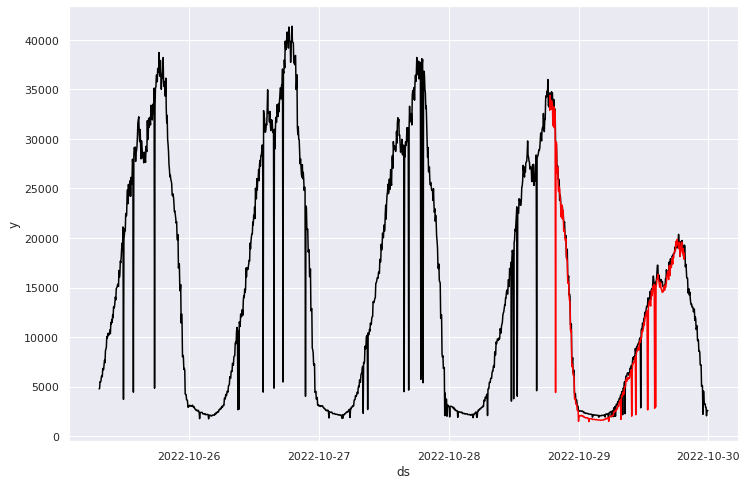

In [ ]:
sns.lineplot(x=df.index[7000:], y='y', data=df[7000:], color='black')
sns.lineplot(x=df.index[8000:8300], y='y_pred_naive', data=df[8000:8300], color='red')

In [ ]:
def holtwin(y_to_train, seasonal_period, predict_date):
    
    holt = ExponentialSmoothing(y_to_train, seasonal_periods=seasonal_period, trend='add', seasonal='add',use_boxcox=True).fit()
    y_forecast = holt.forecast(predict_date).rename('Additive')  
    return y_forecast



# Holt Winters

In [ ]:
y_holtwin_pred = holtwin(df['y'][:8000],2016,300)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)


In [ ]:
performance_holtwint_MAE = mean_absolute_error(df['y'][8000:8300], y_holtwin_pred)
print(f'The MAE for the model is {performance_holtwint_MAE}')
performance_holtwint_MAPE = mean_absolute_percentage_error(df['y'][8000:8300], y_holtwin_pred)
print(f'The MAPE for the model is {performance_holtwint_MAPE}')

The MAE for the model is 1780.0395498756359
The MAPE for the model is 0.2122017924277474


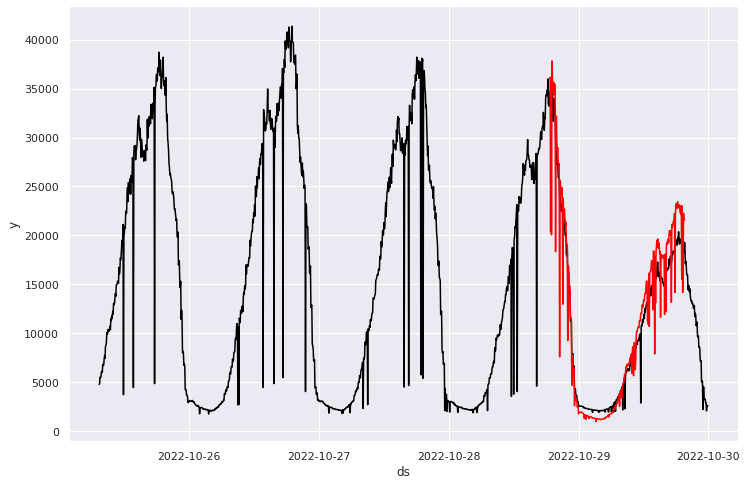

In [ ]:
sns.lineplot(x=df.index[7000:], y='y', data=df[7000:], color='black')
sns.lineplot(x=df.index[8000:8300], y=y_holtwin_pred, color='red')

# Prophet

In [ ]:
m = Prophet().fit(metric_df[:8000])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp16oh7js8/wq_a0583.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp16oh7js8/eyb2mz7v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64797', 'data', 'file=/tmp/tmp16oh7js8/wq_a0583.json', 'init=/tmp/tmp16oh7js8/eyb2mz7v.json', 'output', 'file=/tmp/tmp16oh7js8/prophet_model5tzg2xl7/prophet_model-20221216101153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:11:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:11:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


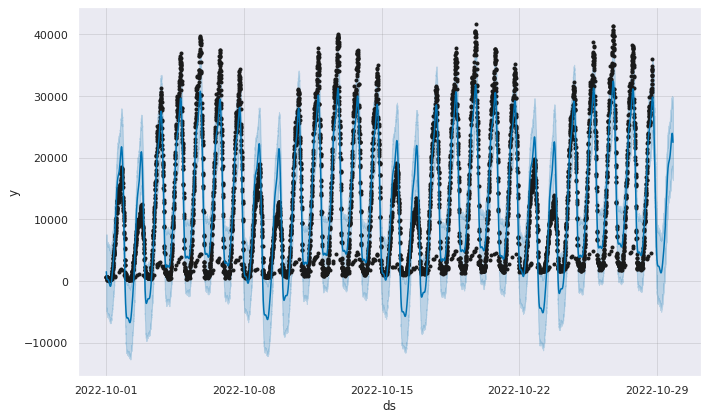

In [ ]:
future = m.make_future_dataframe(periods=1500,freq="min")
y_prophet_pred = m.predict(future)
fig = m.plot(y_prophet_pred)

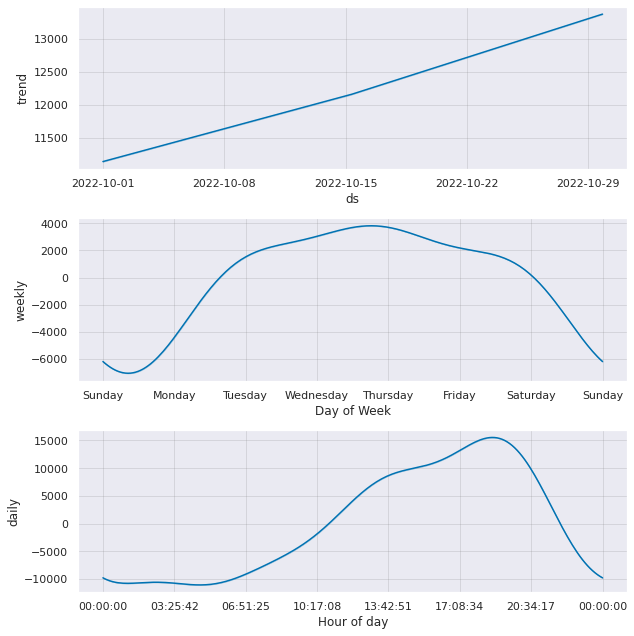

In [ ]:
fig = m.plot_components(y_prophet_pred)

In [ ]:
y_prophet_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-10-01 00:00:01,11030.969643,-4191.422999,6743.565303,11030.969643,11030.969643,-9637.634096,-9637.634096,-9637.634096,-9793.808175,-9793.808175,-9793.808175,156.174079,156.174079,156.174079,0.0,0.0,0.0,1393.335548
1,2022-10-01 00:05:01,11032.416501,-4214.381262,6804.340062,11032.416501,11032.416501,-9816.927254,-9816.927254,-9816.927254,-9956.822810,-9956.822810,-9956.822810,139.895557,139.895557,139.895557,0.0,0.0,0.0,1215.489247
2,2022-10-01 00:10:01,11033.863359,-4592.129638,6709.844831,11033.863359,11033.863359,-9979.363611,-9979.363611,-9979.363611,-10102.887950,-10102.887950,-10102.887950,123.524339,123.524339,123.524339,0.0,0.0,0.0,1054.499748
3,2022-10-01 00:15:01,11035.310217,-4731.302206,6631.782713,11035.310217,11035.310217,-10125.650474,-10125.650474,-10125.650474,-10232.710968,-10232.710968,-10232.710968,107.060494,107.060494,107.060494,0.0,0.0,0.0,909.659742
4,2022-10-01 00:20:01,11036.757074,-4893.020830,6137.998876,11036.757074,11036.757074,-10256.545202,-10256.545202,-10256.545202,-10347.049295,-10347.049295,-10347.049295,90.504094,90.504094,90.504094,0.0,0.0,0.0,780.211872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9495,2022-10-29 19:31:01,13250.993675,17130.455412,27832.946970,13241.552621,13260.991432,9232.877347,9232.877347,9232.877347,14451.938915,14451.938915,14451.938915,-5219.061568,-5219.061568,-5219.061568,0.0,0.0,0.0,22483.871021
9496,2022-10-29 19:32:01,13251.041951,16858.047834,27476.297851,13241.584369,13261.051202,9182.349059,9182.349059,9182.349059,14405.913931,14405.913931,14405.913931,-5223.564872,-5223.564872,-5223.564872,0.0,0.0,0.0,22433.391010
9497,2022-10-29 19:33:01,13251.090227,16955.669240,27709.048254,13241.616116,13261.122262,9130.840338,9130.840338,9130.840338,14358.905262,14358.905262,14358.905262,-5228.064925,-5228.064925,-5228.064925,0.0,0.0,0.0,22381.930564
9498,2022-10-29 19:34:01,13251.138502,16823.737627,27730.781286,13241.647864,13261.193322,9078.351210,9078.351210,9078.351210,14310.912928,14310.912928,14310.912928,-5232.561718,-5232.561718,-5232.561718,0.0,0.0,0.0,22329.489712


In [ ]:
performance_prophet_MAE = mean_absolute_error(metric_df['y'][8000:8300], y_prophet_pred['yhat'][8000:9500:5])
print(f'The MAE for the model is {performance_prophet_MAE}')
performance_prophet_MAPE = mean_absolute_percentage_error(metric_df['y'][8000:8300], y_prophet_pred['yhat'][8000:9500:5])
print(f'The MAPE for the model is {performance_prophet_MAPE}')

The MAE for the model is 1959.4359010192254
The MAPE for the model is 0.19392876052001973


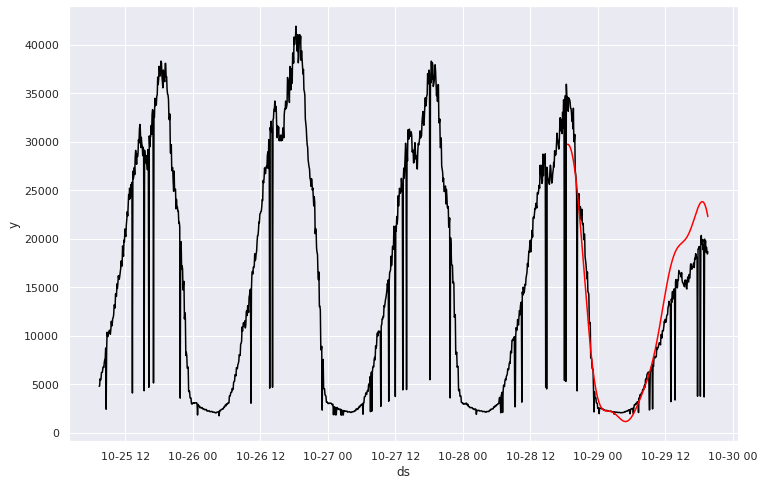

In [ ]:
sns.lineplot(x='ds', y='y', data=metric_df[7000:8300], color='black')
sns.lineplot(x='ds', y='yhat', data=y_prophet_pred[8000:], color='red')

In [ ]:
time_steps = 2016
next_predict = 300

In [ ]:
train_pct = 0.95


In [ ]:
#train_df, test_df = metric_df.iloc[:train_size], metric_df.iloc[train_size:]

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(metric_df[['y']])
metric_df['y_scaled']=scaler.transform(metric_df[['y']])


In [ ]:
metric_df.y_scaled.shape

(8352,)

In [ ]:
Xs, ys, ys_next = [], [], []
for i in range(metric_df.shape[0] - (time_steps+next_predict)):
    v = metric_df[['y_scaled']].iloc[i:(i + time_steps)].values
    Xs.append(v)
    w = metric_df[['y_scaled']].iloc[(i+time_steps):(i + time_steps+next_predict)].values
    ys.append(w)
    
x = np.array(Xs) 
y = np.array(ys)


In [ ]:
x.shape

(6036, 2016, 1)

In [ ]:
y.shape

(6036, 300, 1)

In [ ]:
train_size = int(x.shape[0]*train_pct)
test_size = x.shape[0]-train_size

In [ ]:
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# LSTM Model

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=256,input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences=True,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(units=256,return_sequences=False))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1024,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=512,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=next_predict))
model.add(keras.layers.Dropout(rate=0.2))

opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='mse',optimizer =opt ,metrics=['mse'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2016, 256)         264192    
                                                                 
 dropout (Dropout)           (None, 2016, 256)         0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1024)              263168    
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               5

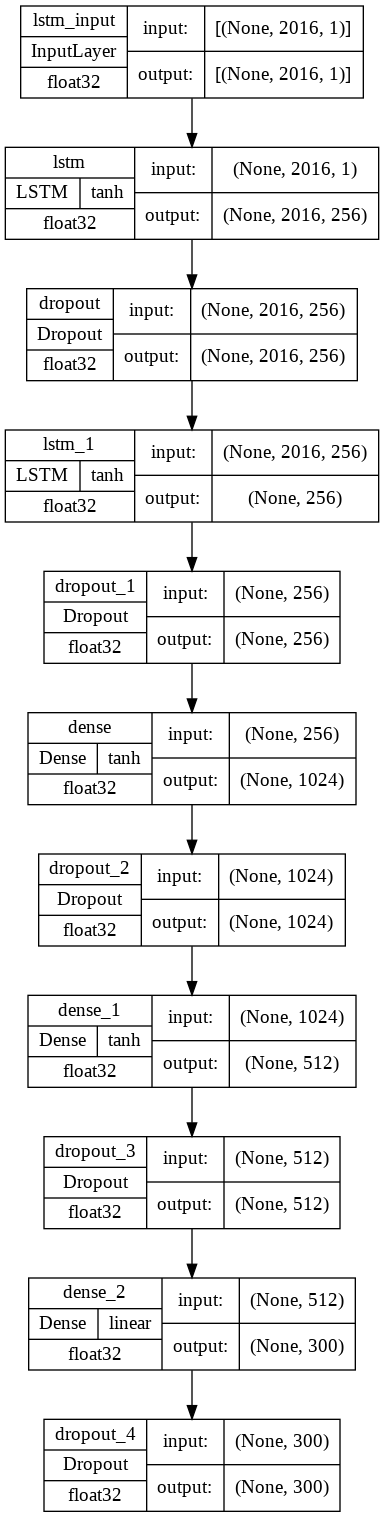

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
filepath=join(path_files,"weights_lstm_forecast_mse_2016_300_best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_mse', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
model.load_weights(join(path_files,"weights_lstm_forecast_mse_2016_300_best.hdf5"))

In [ ]:
history = model.fit(x_train,y_train, epochs =50 , batch_size=128,validation_split=0.1,shuffle = False,callbacks=callbacks_list,verbose=1)

Epoch 1/50
41/41 [==============================] - ETA: 0s - loss: 2.6493 - mse: 2.6493
Epoch 1: val_mse improved from inf to 1.69661, saving model to /content/drive/MyDrive/Colab Notebooks/final/UC4/weights_lstm_forecast_mse_2016_300_best.hdf5
41/41 [==============================] - 32s 601ms/step - loss: 2.6493 - mse: 2.6493 - val_loss: 1.6966 - val_mse: 1.6966
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 2.0405 - mse: 2.0405
Epoch 2: val_mse improved from 1.69661 to 1.66438, saving model to /content/drive/MyDrive/Colab Notebooks/final/UC4/weights_lstm_forecast_mse_2016_300_best.hdf5
41/41 [==============================] - 25s 616ms/step - loss: 2.0405 - mse: 2.0405 - val_loss: 1.6644 - val_mse: 1.6644
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 1.9688 - mse: 1.9688
Epoch 3: val_mse did not improve from 1.66438
41/41 [==============================] - 25s 608ms/step - loss: 1.9688 - mse: 1.9688 - val_loss: 1.6820 - val_mse: 1.6820
Epo

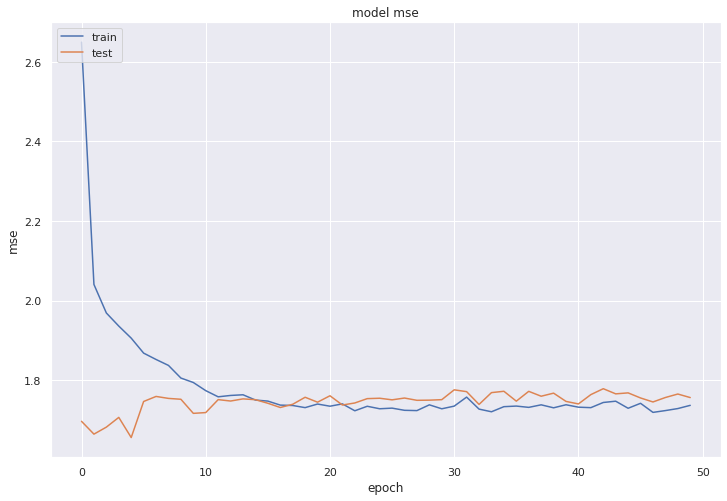

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save_weights(join(path_files,"weights_lstm_forecast_mse_2016_300_best.hdf5"))

In [ ]:
y_pred = model.predict(x)

189/189 [==============================] - 17s 84ms/step


In [ ]:
score, acc = model.evaluate(x_test, y_test)

10/10 [==============================] - 1s 93ms/step - loss: 1.6228 - mse: 1.6228


In [ ]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 1.6228259801864624
Test accuracy: 1.6228259801864624


In [ ]:

performance_lstm_MAE = mean_absolute_error(metric_df['y'][8000:8300], scaler.inverse_transform(y_pred[8000-time_steps,:].reshape(1,-1)).reshape(-1))
print(f'The MAE for the model is {performance_lstm_MAE}')
performance_lstm_MAPE = mean_absolute_percentage_error(metric_df['y'][8000:8300],scaler.inverse_transform(y_pred[8000-time_steps,:].reshape(1,-1)).reshape(-1))
print(f'The MAPE for the model is {performance_lstm_MAPE}')

The MAE for the model is 9639.735986333548
The MAPE for the model is 2.6001506444228877


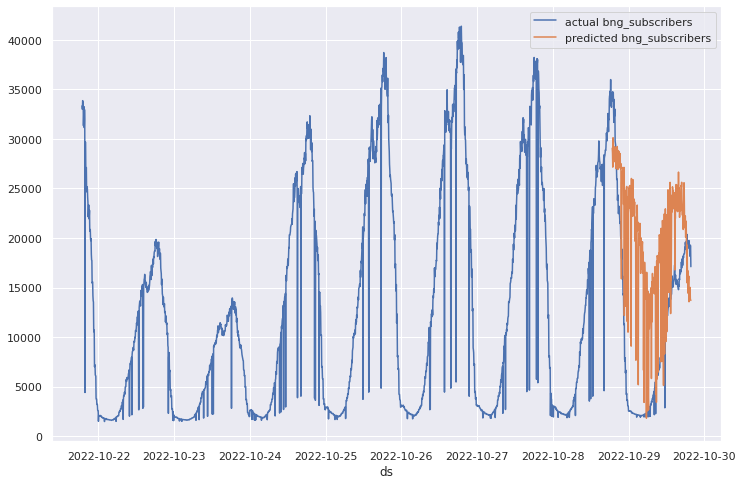

In [ ]:
scope = 2016
sample = 50
sns.lineplot(
      x= metric_df[-(next_predict+scope+sample):-(sample)].ds, 
      y= metric_df['y'][-(next_predict+scope+sample):-(sample)].values.reshape(1,-1).reshape(-1), 
      label='actual bng_subscribers'
    )

sns.lineplot(
      x= metric_df[-(next_predict+sample):-sample].ds, 
      y= scaler.inverse_transform(y_pred[-sample,:].reshape(1,-1)).reshape(-1), 
      label='predicted bng_subscribers'
    )

# Dense model

model for n prediction with dense

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(units=1024,input_shape=(x_train.shape[1],),activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1024,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=512,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=next_predict))
model.add(keras.layers.Dropout(rate=0.2))


opt = keras.optimizers.Adam(learning_rate=0.0005)


model.compile(loss='mse',optimizer =opt,metrics=['mse'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              2065408   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 300)              

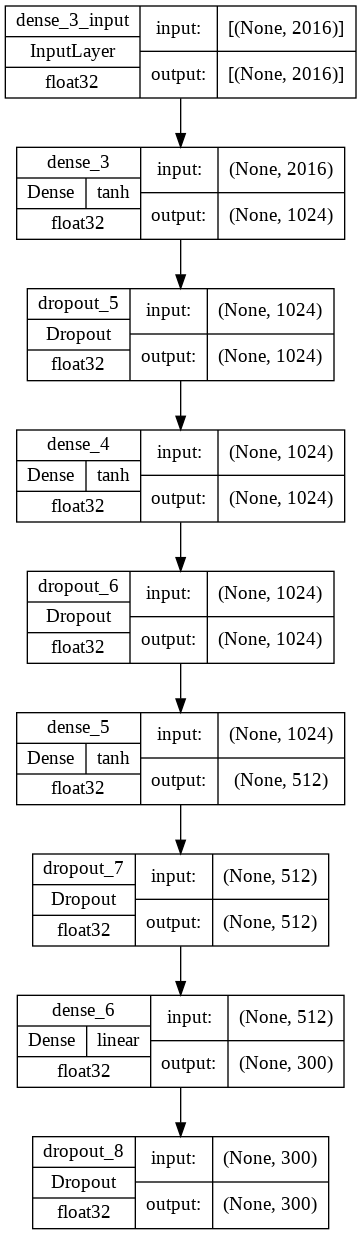

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
filepath=join(path_files,"weights_dense_forecast_mse_2016_300_best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_mse', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
model.load_weights(join(path_files,"weights_dense_forecast_mse_2016_300_best.hdf5"))

In [ ]:
history = model.fit(x_train,y_train, epochs =50 , batch_size=128,validation_split=0.1,shuffle = False,callbacks=callbacks_list,verbose=1)

Epoch 1/50
33/41 [=======================>......] - ETA: 0s - loss: 0.8876 - mse: 0.8876
Epoch 1: val_mse improved from inf to 0.43139, saving model to /content/drive/MyDrive/Colab Notebooks/final/UC4/weights_dense_forecast_mse_2016_300_best.hdf5
41/41 [==============================] - 1s 12ms/step - loss: 0.8718 - mse: 0.8718 - val_loss: 0.4314 - val_mse: 0.4314
Epoch 2/50
35/41 [========================>.....] - ETA: 0s - loss: 0.7136 - mse: 0.7136
Epoch 2: val_mse did not improve from 0.43139
41/41 [==============================] - 0s 5ms/step - loss: 0.7152 - mse: 0.7152 - val_loss: 0.4431 - val_mse: 0.4431
Epoch 3/50
37/41 [==========================>...] - ETA: 0s - loss: 0.6808 - mse: 0.6808
Epoch 3: val_mse improved from 0.43139 to 0.30513, saving model to /content/drive/MyDrive/Colab Notebooks/final/UC4/weights_dense_forecast_mse_2016_300_best.hdf5
41/41 [==============================] - 0s 9ms/step - loss: 0.6855 - mse: 0.6855 - val_loss: 0.3051 - val_mse: 0.3051
Epoch 4/5

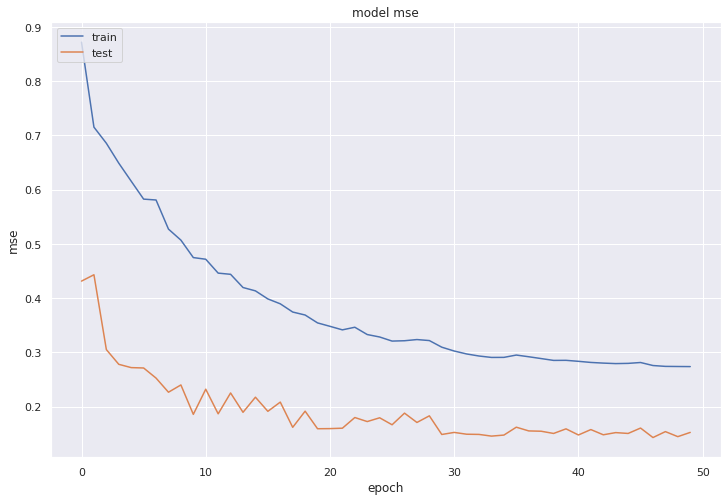

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save_weights(join(path_files,"weights_dense_forecast_mse_2016_300_best.hdf5"))

In [ ]:
y_pred = model.predict(x)

189/189 [==============================] - 0s 2ms/step


In [ ]:
score, acc = model.evaluate(x_test, y_test)

10/10 [==============================] - 0s 3ms/step - loss: 0.0676 - mse: 0.0676


In [ ]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.0676407739520073
Test accuracy: 0.0676407739520073


In [ ]:

performance_dense_MAE = mean_absolute_error(metric_df['y'][8000:8300], scaler.inverse_transform(y_pred[8000-time_steps,:].reshape(1,-1)).reshape(-1))
print(f'The MAE for the model is {performance_dense_MAE}')

performance_dense_MAPE = mean_absolute_percentage_error(metric_df['y'][8000:8300],scaler.inverse_transform(y_pred[8000-time_steps,:].reshape(1,-1)).reshape(-1))
print(f'The MAPE for the model is {performance_dense_MAPE}')

The MAE for the model is 2087.0599304320513
The MAPE for the model is 0.4852318689866937


In [ ]:
scope = 2000
sample = 8000
sns.lineplot(
      x= metric_df[sample:(sample+next_predict)].ds, 
      y= scaler.inverse_transform(y[sample-time_steps,:,0].reshape(1,-1)).reshape(-1), 
      label='actual bng_subscribers'
    )

sns.lineplot(
      x= metric_df[sample:(sample+next_predict)].ds, 
      y= scaler.inverse_transform(y_pred[sample-time_steps,:].reshape(1,-1)).reshape(-1), 
      label='predicted bng_subscribers'
    )

IndexError: ignored

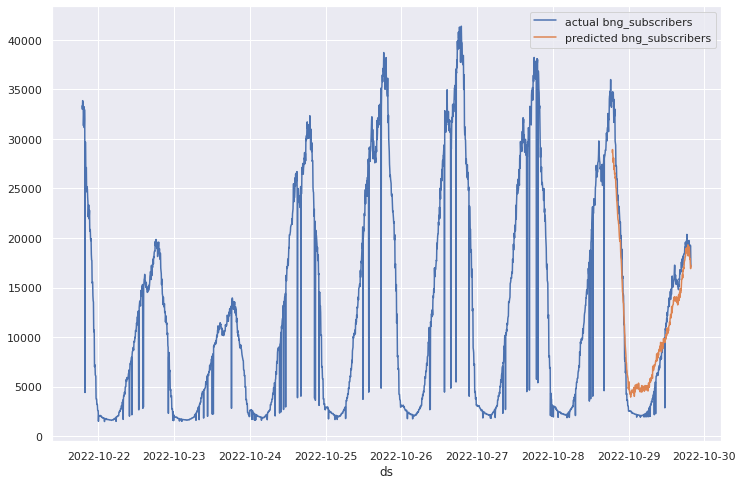

In [ ]:
scope = 2016
sample = 50
sns.lineplot(
      x= metric_df[-(next_predict+scope+sample):-(sample)].ds, 
      y= metric_df['y'][-(next_predict+scope+sample):-(sample)].values.reshape(1,-1).reshape(-1), 
      label='actual bng_subscribers'
    )

sns.lineplot(
      x= metric_df[-(next_predict+sample):-sample].ds, 
      y= scaler.inverse_transform(y_pred[-sample,:].reshape(1,-1)).reshape(-1), 
      label='predicted bng_subscribers'
    )

# Auto ARIMA model

In [ ]:
model = auto_arima(
	df['y'][:8000],
	trace=True,
	error_action="ignore",
	suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=152987.201, Time=1.87 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=156738.480, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=154555.546, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=153037.614, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=156736.487, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=153038.484, Time=1.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=152973.487, Time=1.79 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=153008.710, Time=1.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=153593.265, Time=0.72 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=152971.638, Time=2.84 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=153249.142, Time=0.83 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=152959.047, Time=3.70 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=153087.652, Time=1.07 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=152946.541, Time=4.47 sec
 ARIM

In [ ]:
forecast_arima = model.predict(n_periods=300)

In [ ]:
forecast_arima

2022-10-28 18:40:01    34764.977555
2022-10-28 18:45:01    35071.212914
2022-10-28 18:50:01    35106.829631
2022-10-28 18:55:01    35420.161619
2022-10-28 19:00:01    35466.518599
                           ...     
2022-10-29 19:15:01    39616.533232
2022-10-29 19:20:01    39616.364399
2022-10-29 19:25:01    39616.195463
2022-10-29 19:30:01    39616.026413
2022-10-29 19:35:01    39615.857267
Freq: 5T, Length: 300, dtype: float64

In [ ]:
performance_arima_MAE = mean_absolute_error(metric_df['y'][8000:8300], forecast_arima.values)
print(f'The MAE for the model is {performance_arima_MAE}')

performance_arima_MAPE = mean_absolute_percentage_error(metric_df['y'][8000:8300], forecast_arima.values)
print(f'The MAPE for the model is {performance_arima_MAPE}')

The MAE for the model is 27988.85831417153
The MAPE for the model is 6.849769941482685


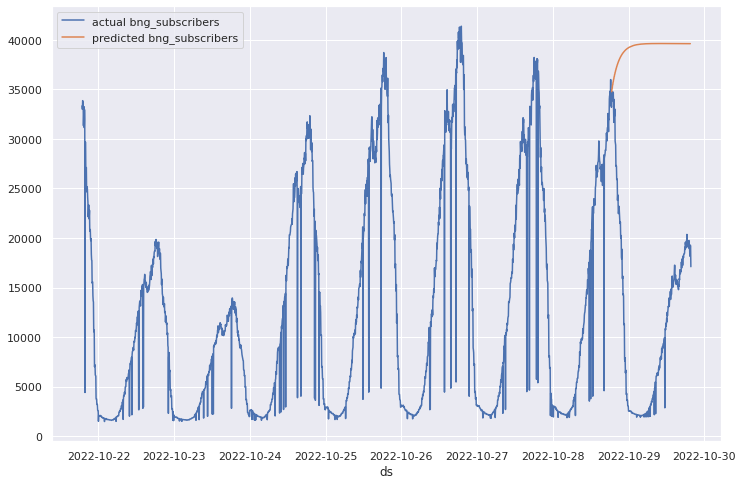

In [ ]:
scope = 2016
sample = 50
sns.lineplot(
      x= metric_df[-(next_predict+scope+sample):-(sample)].ds, 
      y= metric_df['y'][-(next_predict+scope+sample):-(sample)].values.reshape(1,-1).reshape(-1), 
      label='actual bng_subscribers'
    )

sns.lineplot(
      x= forecast_arima.index, 
      y= forecast_arima, 
      label='predicted bng_subscribers'
    )

# LSTM with short and long term input vectors

In [ ]:
time_steps = 288
next_predict = 300
long_term = 2016

In [ ]:
metric_df

,timestamp,bng_subscribers,device_name,vendor,model,os,version,hw_revision,role,ip_address,ds,y,y_scaled
0,1664582401,700.572875,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-01 00:00:01,700.572875,-1.026162
1,1664582701,699.180130,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-01 00:05:01,699.180130,-1.026288
2,1664583001,708.998684,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-01 00:10:01,708.998684,-1.025402
3,1664583301,688.517726,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-01 00:15:01,688.517726,-1.027249
4,1664583601,718.203977,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-01 00:20:01,718.203977,-1.024572
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8347,1667086501,2891.532965,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-29 23:35:01,2891.532965,-0.828635
8348,1667086801,2051.840208,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-29 23:40:01,2051.840208,-0.904338
8349,1667087101,2591.565752,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-29 23:45:01,2591.565752,-0.855679
8350,1667087401,2592.219241,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2022-10-29 23:50:01,2592.219241,-0.855620


In [ ]:
Xs, ys, Xl = [], [], []
for i in range(metric_df.shape[0] - (long_term+next_predict)):
    v = metric_df[['y_scaled']].iloc[(i+long_term-time_steps):(i + long_term)].values
    Xs.append(v)
    long_term_segment = metric_df[['ds','y_scaled']].iloc[i:(i + long_term)].copy()
    long_term_summary = long_term_segment.resample('35T',on='ds').mean().values
    Xl.append(long_term_summary[:time_steps])
    w = metric_df[['y_scaled']].iloc[(i+time_steps):(i + time_steps+next_predict)].values
    ys.append(w)
    
xs = np.array(Xs) 
xl = np.array(Xl) 
y = np.array(ys)


In [ ]:
xl.shape

(6036, 288, 1)

In [ ]:
x = np.concatenate((xs,xl),axis=2)

In [ ]:
x.shape

(6036, 288, 2)

In [ ]:
train_size = int(x.shape[0]*train_pct)
test_size = x.shape[0]-train_size

In [ ]:
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=256,input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences=True,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(units=256,return_sequences=False))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1024,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=512,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=next_predict))
model.add(keras.layers.Dropout(rate=0.2))

opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='mse',optimizer =opt ,metrics=['mse'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 288, 256)          265216    
                                                                 
 dropout_30 (Dropout)        (None, 288, 256)          0         
                                                                 
 lstm_15 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_31 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 1024)              263168    
                                                                 
 dropout_32 (Dropout)        (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 512)              

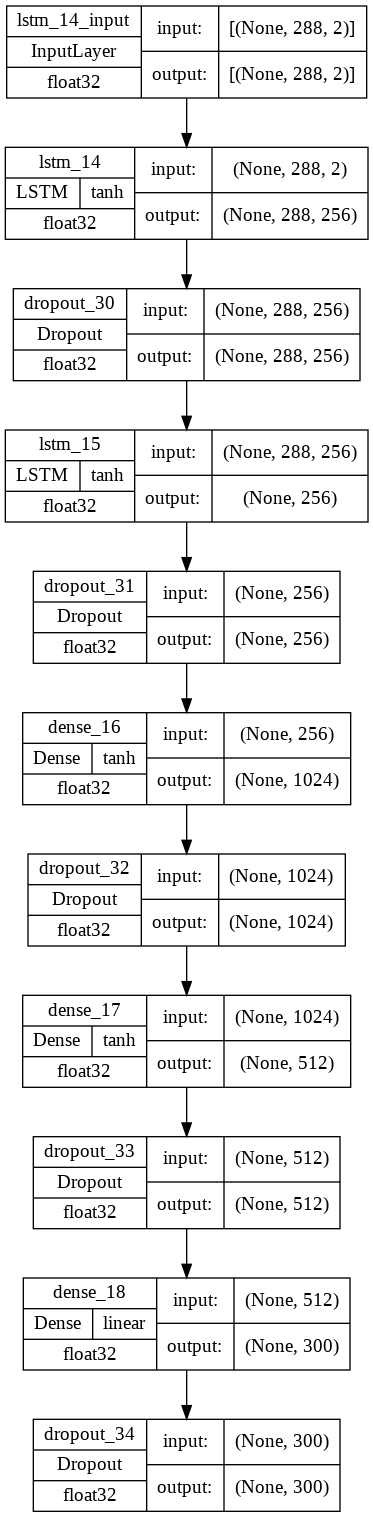

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
filepath=join(path_files,"weights_lstm_sl_forecast_mse_best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='mse', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
model.load_weights(join(path_files,"weights_lstm_sl_forecast_mse_best.hdf5"))

In [ ]:
history = model.fit(x_train,y_train, epochs =50 , batch_size=128,validation_split=0.1,shuffle = False,callbacks=callbacks_list,verbose=1)

Epoch 1/50
40/41 [============================>.] - ETA: 0s - loss: 3.3175 - mse: 3.3175
Epoch 1: mse improved from inf to 3.30862, saving model to /content/drive/MyDrive/Colab Notebooks/final/UC4/weights_lstm_sl_forecast_mse_best.hdf5
41/41 [==============================] - 7s 103ms/step - loss: 3.3086 - mse: 3.3086 - val_loss: 1.1424 - val_mse: 1.1424
Epoch 2/50
40/41 [============================>.] - ETA: 0s - loss: 1.3690 - mse: 1.3690
Epoch 2: mse improved from 3.30862 to 1.37489, saving model to /content/drive/MyDrive/Colab Notebooks/final/UC4/weights_lstm_sl_forecast_mse_best.hdf5
41/41 [==============================] - 3s 83ms/step - loss: 1.3749 - mse: 1.3749 - val_loss: 1.1981 - val_mse: 1.1981
Epoch 3/50
40/41 [============================>.] - ETA: 0s - loss: 1.3866 - mse: 1.3866
Epoch 3: mse did not improve from 1.37489
41/41 [==============================] - 3s 80ms/step - loss: 1.3929 - mse: 1.3929 - val_loss: 1.2744 - val_mse: 1.2744
Epoch 4/50
40/41 [==============

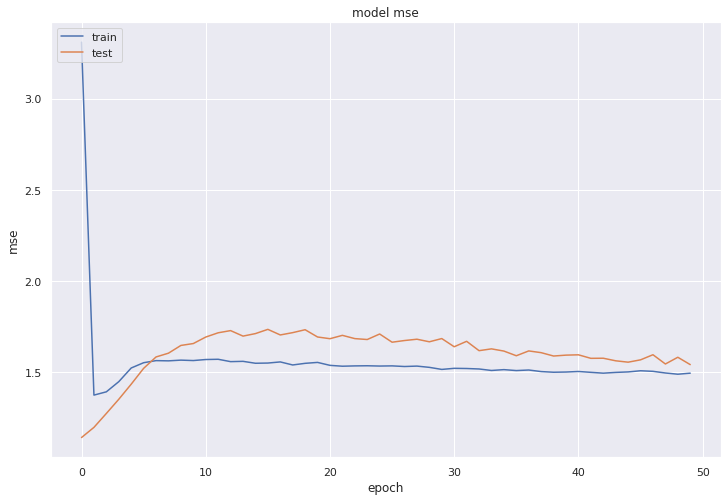

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(x)

189/189 [==============================] - 3s 13ms/step


In [ ]:
y_pred.shape

(6036, 300)

In [ ]:
score, acc = model.evaluate(x_test, y_test)

10/10 [==============================] - 0s 24ms/step - loss: 0.8821 - mse: 0.8821


In [ ]:

performance_lstm_ls_MAE = mean_absolute_error(metric_df['y'][8000:8300], scaler.inverse_transform(y_pred[8000-long_term,:].reshape(1,-1)).reshape(-1))
print(f'The MAE for the model is {performance_lstm_ls_MAE}')
# Check MAPE value
performance_lstm_ls_MAPE = mean_absolute_percentage_error(metric_df['y'][8000:8300],scaler.inverse_transform(y_pred[8000-long_term,:].reshape(1,-1)).reshape(-1))
print(f'The MAPE for the model is {performance_lstm_ls_MAPE}')

The MAE for the model is 5363.503886776813
The MAPE for the model is 0.8154936431481645


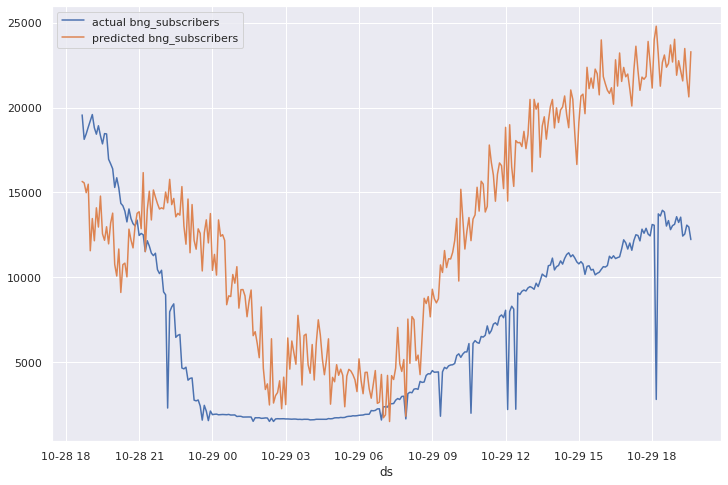

In [ ]:
scope = 2000
sample = 8000
sns.lineplot(
      x= metric_df[sample:(sample+next_predict)].ds, 
      y= scaler.inverse_transform(y[sample-long_term,:,0].reshape(1,-1)).reshape(-1), 
      label='actual bng_subscribers'
    )

sns.lineplot(
      x= metric_df[sample:(sample+next_predict)].ds, 
      y= scaler.inverse_transform(y_pred[sample-long_term,:].reshape(1,-1)).reshape(-1), 
      label='predicted bng_subscribers'
    )

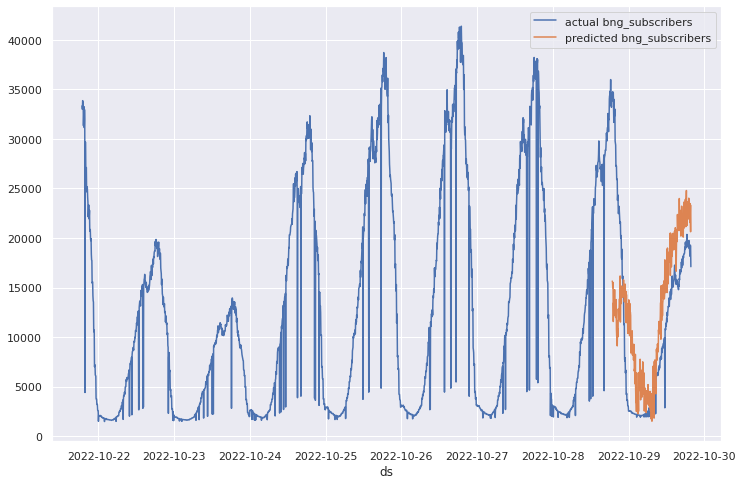

In [ ]:
scope = 2016
sample = 50
sns.lineplot(
      x= metric_df[-(next_predict+scope+sample):-(sample)].ds, 
      y= metric_df['y'][-(next_predict+scope+sample):-(sample)].values.reshape(1,-1).reshape(-1), 
      label='actual bng_subscribers'
    )

sns.lineplot(
      x= metric_df[-(next_predict+sample):-sample].ds, 
      y= scaler.inverse_transform(y_pred[-sample,:].reshape(1,-1)).reshape(-1), 
      label='predicted bng_subscribers'
    )

# Dense network with long and short term data

In [ ]:
x=x.reshape((x.shape[0],x.shape[1]*x.shape[2]))

In [ ]:
x.shape

(6036, 576)

In [ ]:
y.shape

(6036, 300, 1)

In [ ]:
train_size = int(x.shape[0]*train_pct)
test_size = x.shape[0]-train_size

In [ ]:
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(units=1024,input_shape=(x_train.shape[1],),activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1024,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=512,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=next_predict))
model.add(keras.layers.Dropout(rate=0.2))


opt = keras.optimizers.Adam(learning_rate=0.0005)


model.compile(loss='mse',optimizer =opt,metrics=['mse'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1024)              590848    
                                                                 
 dropout_26 (Dropout)        (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_27 (Dropout)        (None, 1024)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               524800    
                                                                 
 dropout_28 (Dropout)        (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 300)              

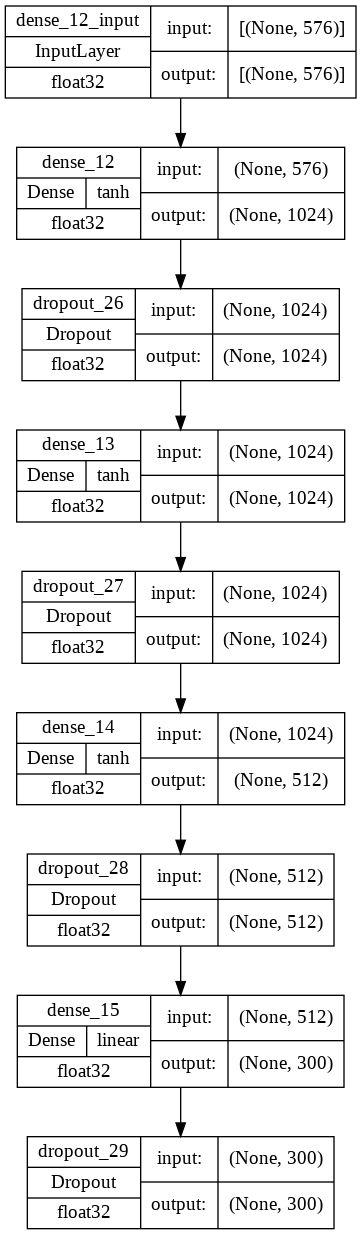

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
filepath=join(path_files,"weights_dense_ls_forecast_mse_288_300_best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_mse', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
model.load_weights(join(path_files,"weights_dense_ls_forecast_mse_288_300_best.hdf5"))

In [ ]:
history = model.fit(x_train,y_train, epochs =50 , batch_size=128,validation_split=0.1,shuffle = False,callbacks=callbacks_list,verbose=1)

Epoch 1/50
37/41 [==========================>...] - ETA: 0s - loss: 0.8820 - mse: 0.8820
Epoch 1: val_mse improved from inf to 0.51597, saving model to /content/drive/MyDrive/Colab Notebooks/final/UC4/weights_dense_ls_forecast_mse_288_300_best.hdf5
41/41 [==============================] - 1s 11ms/step - loss: 0.8991 - mse: 0.8991 - val_loss: 0.5160 - val_mse: 0.5160
Epoch 2/50
40/41 [============================>.] - ETA: 0s - loss: 0.7293 - mse: 0.7293
Epoch 2: val_mse did not improve from 0.51597
41/41 [==============================] - 0s 5ms/step - loss: 0.7300 - mse: 0.7300 - val_loss: 0.6487 - val_mse: 0.6487
Epoch 3/50
29/41 [====================>.........] - ETA: 0s - loss: 0.7814 - mse: 0.7814
Epoch 3: val_mse improved from 0.51597 to 0.49059, saving model to /content/drive/MyDrive/Colab Notebooks/final/UC4/weights_dense_ls_forecast_mse_288_300_best.hdf5
41/41 [==============================] - 0s 7ms/step - loss: 0.7603 - mse: 0.7603 - val_loss: 0.4906 - val_mse: 0.4906
Epoch

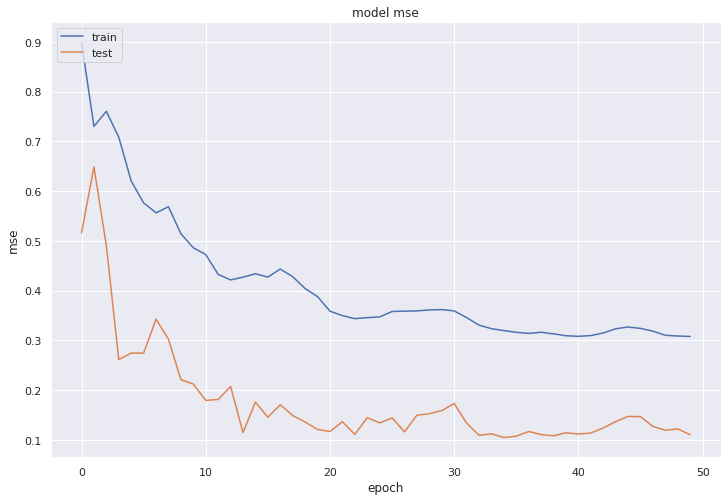

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save_weights(join(path_files,"weights_dense_ls_forecast_mse_288_300_best.hdf5"))

In [ ]:
y_pred = model.predict(x)

189/189 [==============================] - 0s 1ms/step


In [ ]:
score, acc = model.evaluate(x_test, y_test)

10/10 [==============================] - 0s 3ms/step - loss: 0.0383 - mse: 0.0383


In [ ]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.03828854858875275
Test accuracy: 0.03828854858875275


In [ ]:
performance_dense_ls_MAE = mean_absolute_error(metric_df['y'][8000:8300], scaler.inverse_transform(y_pred[8000-long_term,:].reshape(1,-1)).reshape(-1))
print(f'The MAE for the model is {performance_dense_ls_MAE}')

performance_dense_ls_MAPE = mean_absolute_percentage_error(metric_df['y'][8000:8300],scaler.inverse_transform(y_pred[8000-long_term,:].reshape(1,-1)).reshape(-1))
print(f'The MAPE for the model is {performance_dense_ls_MAPE}')

The MAE for the model is 4112.138385212828
The MAPE for the model is 0.34570108467568944


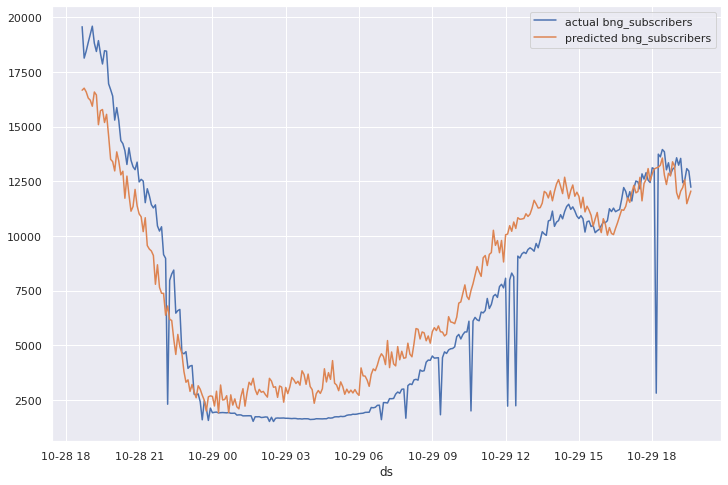

In [ ]:
scope = 2000
sample = 8000
sns.lineplot(
      x= metric_df[sample:(sample+next_predict)].ds, 
      y= scaler.inverse_transform(y[sample-long_term,:,0].reshape(1,-1)).reshape(-1), 
      label='actual bng_subscribers'
    )

sns.lineplot(
      x= metric_df[sample:(sample+next_predict)].ds, 
      y= scaler.inverse_transform(y_pred[sample-long_term,:].reshape(1,-1)).reshape(-1), 
      label='predicted bng_subscribers'
    )

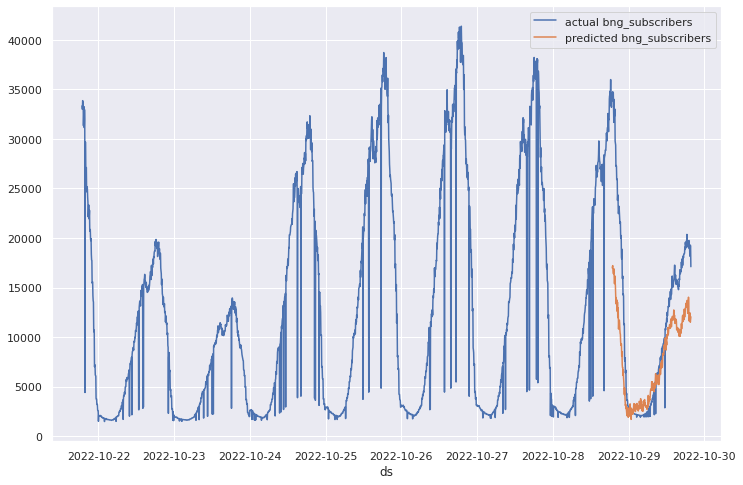

In [ ]:
scope = 2016
sample = 50
sns.lineplot(
      x= metric_df[-(next_predict+scope+sample):-(sample)].ds, 
      y= metric_df['y'][-(next_predict+scope+sample):-(sample)].values.reshape(1,-1).reshape(-1), 
      label='actual bng_subscribers'
    )

sns.lineplot(
      x= metric_df[-(next_predict+sample):-sample].ds, 
      y= scaler.inverse_transform(y_pred[-sample,:].reshape(1,-1)).reshape(-1), 
      label='predicted bng_subscribers'
    )

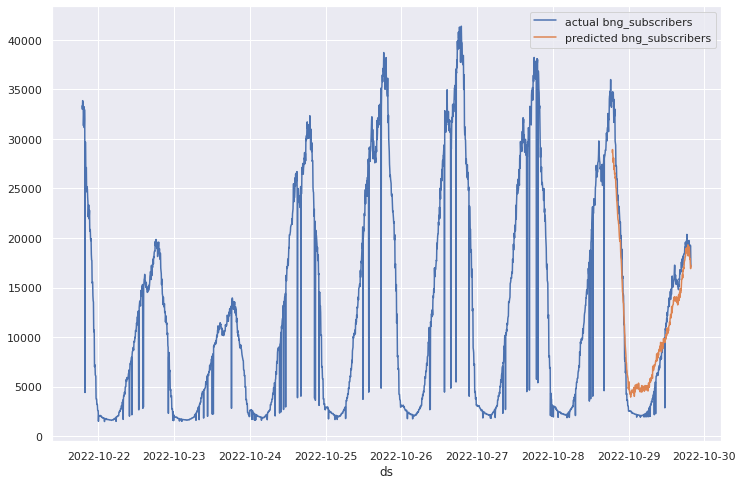

In [ ]:
scope = 2016
sample = 50
sns.lineplot(
      x= metric_df[-(next_predict+scope+sample):-(sample)].ds, 
      y= metric_df['y'][-(next_predict+scope+sample):-(sample)].values.reshape(1,-1).reshape(-1), 
      label='actual bng_subscribers'
    )

sns.lineplot(
      x= metric_df[-(next_predict+sample):-sample].ds, 
      y= scaler.inverse_transform(y_pred[-sample,:].reshape(1,-1)).reshape(-1), 
      label='predicted bng_subscribers'
    )